In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# import required modules
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
from datetime import date
from scipy import signal
from fractions import Fraction
from scipy.io.wavfile import write
pi = np.pi

# Functions for musical interval analysis:
* All specific functions needed for this project (so far) are defined below
* scroll to next section for any output

In [3]:
# DSP functions

# setup plotting dimensions
# setup for dsp (not used yet)
# upsample to Np, power of 2 for N-point (Np) FFT
# input: T seconds long, fs is sample rate (Hz)
def dim_def(T,fs):
    N = round(T * fs)     # number of samples
    n = np.linspace(0,N,N)
    Ts = 1/fs        # delta t
    Ws = 2*np.pi*fs  # sampling freq (rad)
    
    dimensions = {'numsamps':N,'Ts':Ts,'n_index':n}
    return dimensions

# func to zero pad
def zeropad(x,N,fs,trunc):
    # with zero padding, make Np at least 2*N
    k = 5          # N to the kth power
    Np = 2**k      # desired length of zero padded input signal for an N-point FFT
    while N > Np:
        k = k + 1
        Np = 2**k

    f = np.linspace(0, fs, Np)
    Ws = 2*np.pi*fs  # sampling freq (rad)

    # zero pad
    C = int((Np-N)/2)       # index at t = 0
    D = C + N               # index at t = T
    
    z = np.zeros(Np)
    z[C:D] = x
    x = z
    
    plotlen = int(round(Np/trunc))
    return x,Np,plotlen,C,D,Ws

# function to plot fft
# trunc => plotlength = Np/trunc
def plot_fft(x,x_title,N,fs,trunc):
    plotlen = int(round(N/trunc))
    
    #x,N,plotlen,C,D,_ = zeropad(x,N,fs,trunc)
    f = np.linspace(0, fs, N)
    
    Y = scipy.fft.fft(x)
    Y_mag = 20*np.log10(np.absolute(Y))
    fmax = f[np.argmax(Y_mag)]
    
    plt.figure(figsize=(14, 5))
    plt.title('FFT of %s' % x_title)
    plt.plot(f[:plotlen], Y_mag[:plotlen])
    
    plt.vlines(fmax,np.amin(Y_mag[:N//4]),np.amax(Y_mag[:N//4]),colors='r',label='%.1f Hz' %(fmax))
    plt.legend()
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    #plt.show()
    
# Function to find all the local maxima  
# and minima in the given array arr[]
# https://www.geeksforgeeks.org/find-indices-of-all-local-maxima-and-local-minima-in-an-array/
def findLocalMaximaMinima(n, arr):  
    # Empty lists to store points of  
    # local maxima and minima  
    mx = []  
    mn = []  
  
    # Checking whether the first point is  
    # local maxima or minima or neither  
    if(arr[0] > arr[1]):  
        mx.append(0)  
    elif(arr[0] < arr[1]):  
        mn.append(0)  
  
    # Iterating over all points to check  
    # local maxima and local minima  
    for i in range(1, n-1):  
  
        # Condition for local minima  
        if(arr[i-1] > arr[i] < arr[i + 1]):  
            mn.append(i)  
  
        # Condition for local maxima  
        elif(arr[i-1] < arr[i] > arr[i + 1]):  
            mx.append(i)  
  
    # Checking whether the last point is  
    # local maxima or minima or neither  
    if(arr[-1] > arr[-2]):  
        mx.append(n-1)  
    elif(arr[-1] < arr[-2]):  
        mn.append(n-1)
    
    # returns indexes of max (mx) and min (mn) magnitudes in arr
    return mx,mn

# make fade in/fade out
# N samples, sig time series
def fade(N,sig):
    fadelen = int(round(1/10 * N))
    output = sig
    for k in range(fadelen):
        output[k] = k/fadelen * output[k]
    for g in range(fadelen):
        q = (N-1) - g
        output[q] = g/fadelen * output[q]
    return output

# create audio file
# sCount 
def write_audio(array,fs,sCount):
    today = date.today()
    d8 = today.strftime("%b-%d-%Y")
    stitle = 'sound%d_%s.wav' %(sCount,d8)
    
    # normalize audio
    norm = np.linalg.norm(array)
    norm_array = array/norm
    
    sCount = sCount + 1
    write(stitle, fs, norm_array)


In [4]:
# Waveform functions

# function for summing two notes by interval
# N in samples, fs in Hz, fund is string ('A4'),
# interval is an integer (num semitones)
# pitch is given by pitch_dict_create()
def two_pure_tones(N,fs,fund,pitch,interval):
    
    # find fund, select note by given interval:
    f0 = pitch[fund]
    temp = list(pitch)
    try: 
        res = temp[temp.index(fund) + interval] 
    except (ValueError, IndexError): 
        res = None
    fb = pitch[str(res)]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    wb = 2*pi*fb
    
    sin_0 = np.sin(w0*Ts*n)
    sin_b = np.sin(wb*Ts*n)
    x = sin_0 + sin_b
    x_title = '%d half-step interval, %s from %.1f Hz' % (interval,notes['intervals'][interval],f0)
    
    # output is x[] time series, x title string
    return x,x_title

# function for summing odd or even harmonics
# harm is a string ('even','odd','overlay')
# num_harm is an integer
def simple_harmonic(N,fs,fund,pitch,harm,num_harm):
    f0 = pitch[fund]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    
    if harm == 'even':
        sig = np.zeros(N)
        for m in range(num_harm):
            even = 2*(m+1)
            harm = (2/even)*np.sin(w0*even*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d even harmonics' % num_harm
    elif harm == 'odd':
        sig = np.zeros(N)
        for m in range(num_harm):
            odd = 2+(2*m-1)
            harm = (1/odd)*np.sin(w0*odd*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d odd harmonics' % num_harm
    elif harm == 'overlay':
        fig= plt.figure(figsize=(15,6))
        #t = np.linspace(0,Ts*N,N)
        
        Tp = 1/f0
        Nt = int(round(Tp/Ts))
        t = np.linspace(0,Ts*Nt,Nt)
        
        x = np.zeros(N)
        for m in range(num_harm):
            harm = (1/(1+m))*np.sin(w0*(1+m)*Ts*n)
            x = x + harm
            x_title = 'first %d harmonics from %s' % (num_harm,fund)
            plt.plot(t,harm[:len(t)])
            plt.title(x_title)
            plt.xlabel('time (s)')
        plt.show()
    # return chosen time series, title
    return x,x_title

# plot waveform
def plot_waveforms(Ts,N,x,x_title):
    t = np.linspace(0,Ts*N,N)
    fig= plt.figure(figsize=(14,5))

    plt.plot(t,x)
    plt.title(x_title)
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')
    
# plot waveform by frequency
def plot_freq(Ts,N,f1,f2):
    n = np.linspace(0,N,N)
    t = np.linspace(0,Ts*N,N)
    w1 = 2*pi*f1
    w2 = 2*pi*f2
    sin_1 = np.sin(w1*Ts*n)
    sin_2 = np.sin(w2*Ts*n)
    x = sin_1 + sin_2
    
    fig= plt.figure(figsize=(14,5))
    plt.plot(t,x)
    plt.title('%.1f Hz and %.1f Hz' % (f1,f2))
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')

In [5]:
# Musical definitions

# define note names and pitches
def pitch_dict_create():
    
    # init note names and interval names
    note = ["C","Db","D","Eb","E","F","Gb","G","Ab","A","Bb","B"]
    tet = len(note)
    intervals = ['unison','min 2nd','maj 2nd','min 3rd','maj 3rd','prf 4th',
             'tritone','prf 5th','min 6th','maj 6th','dom 7th','maj 7th','octave']
    # init vars
    octave = 0
    count = 0
    note_names = []
    pitch = {}

    # 9 octaves of note names in scientific format
    # ex. A4 is A in the 4th octave, middle A
    for number in range(108):
        note_names.append("%s%d" %(note[number % 12], octave))
        count = count+1
        if count == 12:
            octave = octave+1
            count = 0

    # 9 octaves of pitches matched with note names
    A4 = 440     # A440 pitch standard 440 Hz
    for k in range(108):
        pitch[note_names[k]] = A4 * (2**(1/12))**(k-57)

    # above pitch equation:
    # all notes relative to standard A440 pitch
    # frequency of a pitch relative to standard is:
    # ratio = (2^(1/12))^n
    # where n is the # of half-steps from the standard to the pitch
    # n = k-57 such that n=0 corresponds to A440 with 108 pitches
    
    notes = {'intervals':intervals,'names':note_names,'pitch':pitch}
    return notes
    
# need functions to determine how close 
# the given interval is to a 'simple' one
# the closer to a simple ratio, the more
# consonant the interval

# get ratio info from notes
# b is the higher note, in Hz
def f_to_ratio(b,a):
    b = int(round(b))
    a = int(round(a))
    div = np.gcd(b,a)
    nume = int(b/div)
    deno = int(a/div)
    rat = nume/deno
    return nume,deno,div,rat

# get closest simple ratio
# from num/denom given by f_to_ratio()
def close_to_simple_ratio(nume,deno):
    pmin_diff = 1000
    for i in range(12):
        for j in range(11):
            diff = np.abs(nume/deno - i/(j+1))
            if diff < pmin_diff:
                pmin_diff = diff
                closest_num = i
                closest_den = (j+1)
            else:
                diff = diff
    return closest_num,closest_den,pmin_diff

# function that takes a note and interval, returns the note at interval
def note_interval(fund,interval,note_names):
    fund_index = note_names.index(fund)
    note_index = fund_index + interval
    note = note_names[note_index]
    
    return note

# make lists of various scale intervals
# taken from Jamey Abersold scale syllabus
# scales are listed by step sizes in semitones
scales = {
    'major':      [2,2,1,2,2,2,1],
    'dimW':       [2,1,2,1,2,1,2,1],
    'dimH':       [1,2,1,2,1,2,1,2],
    'pentmaj':    [2,2,3,2,3],
    'bebopmaj':   [2,2,1,2,1,1,2,1],
    'harmmaj':    [2,2,1,2,1,3,1],
    'lydaug':     [2,2,2,2,1,2,1],
    'augment':    [3,1,3,1,3,1],
    'blues':      [3,2,1,1,3,2]
}

# generate modes from major
modes = ['ionian','dorian','phrygian','lydian',
         'mixolydian','aeolian','locrian']
for k in range(6):
    scales[modes[k+1]] = np.roll(scales['major'],-(k+1))

# lists a given scale by name from scales dictionary
# for a given root note
def list_scale(root,name,scales,note_names):
    scale = []
    root_index = note_names.index(root)
    steps = scales[name]
    for k in range(len(steps)):
        index = root_index + sum(steps[:k])
        scale.append(note_names[index])
        
    return scale

In [6]:
# function to get note names of harmonics created by simple_harmonic()
# blah blah blah....

In [7]:
# init vars
sCount = 0

# Harmonic Analysis:
 * Plot time series of even and odd harmonics
 * Plot overlay of harmonic components and correpsonding time series
 * Plot spectral content

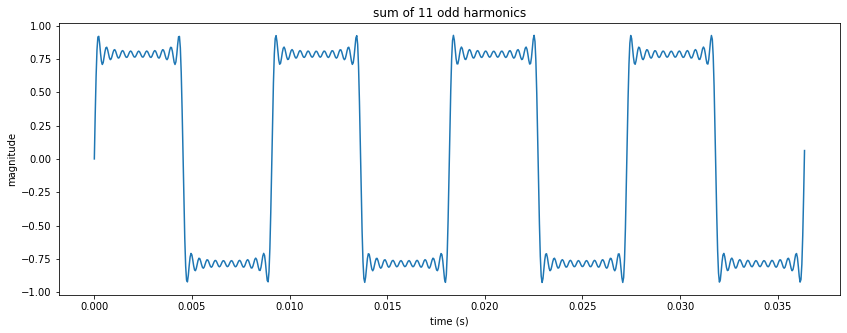

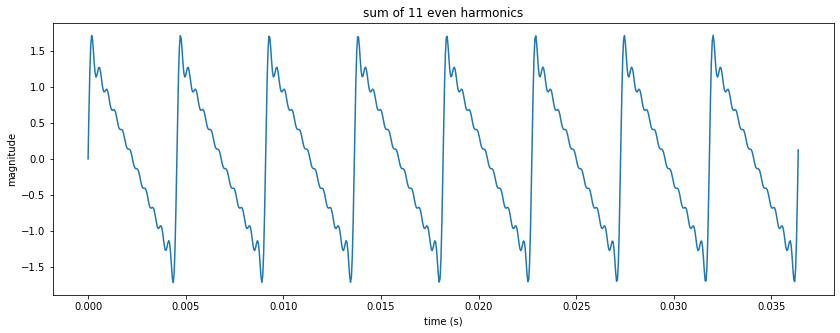

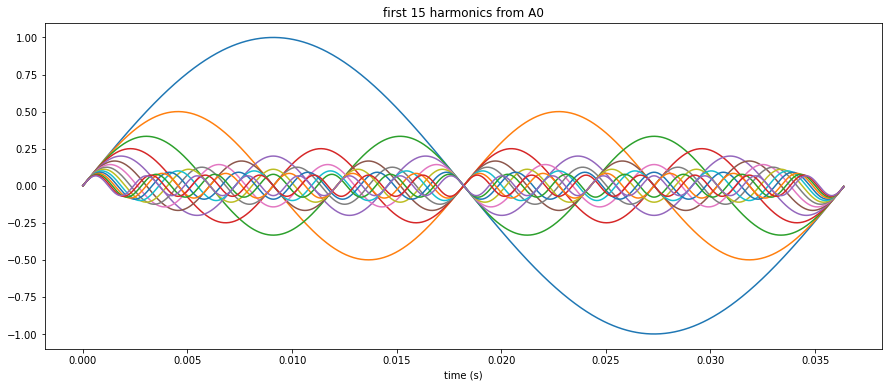

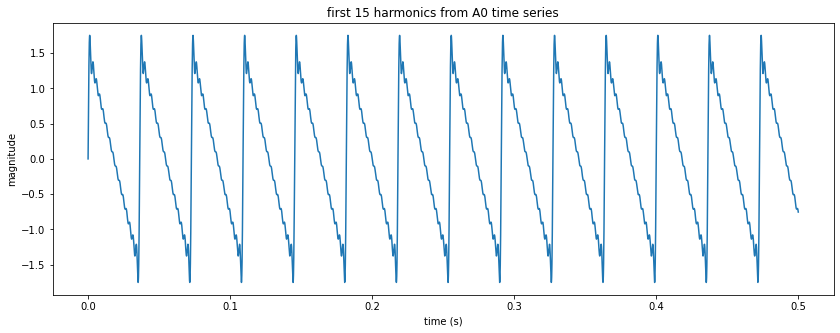

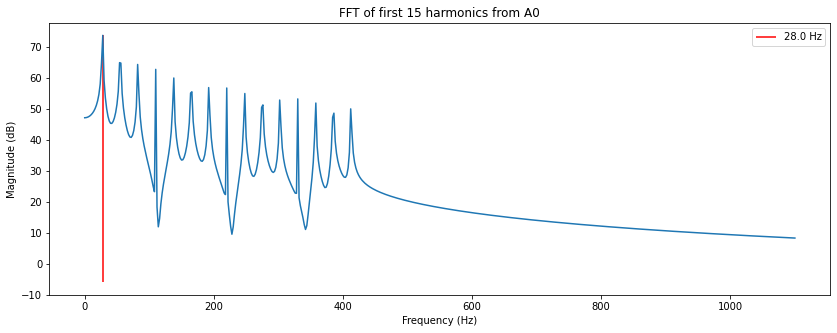

In [9]:
# setup note elements
notes = pitch_dict_create()
intervals = notes['intervals']
note_names = notes['names']
pitch = notes['pitch']

# setup dimensions
T = 1/27.5      # T seconds long
fs = 22050      # Hz
nyq = round(int(22050/2))  # highest freq before aliasing
dimensions = dim_def(T,fs)
Ts = dimensions['Ts']
n = dimensions['n_index']
N = dimensions['numsamps']

# create and plot odd/even harmonic sums
x,x_title = simple_harmonic(N,fs,'A2',pitch,'odd',11)
plot_waveforms(Ts,N,x,x_title)

x,x_title = simple_harmonic(N,fs,'A2',pitch,'even',11)
plot_waveforms(Ts,N,x,x_title)

# plot an overlay of the harmonics
# A0 is at 27.5 Hz, N = 800, therefore:
# 1/(f_A0) ~= N/fs

# time series plot over longer duration
dimensions = dim_def(.5,fs)
Ts = dimensions['Ts']
n = dimensions['n_index']
N = dimensions['numsamps']
x,x_title = simple_harmonic(N,fs,'A0',pitch,'overlay',15)
xt_title = x_title + ' time series'
plot_waveforms(Ts,N,x,xt_title)

# FFT plot
plot_fft(x,x_title,N,fs,20)

# Interval Analysis:
### For each of 13 intervals from the root to the octave:
* Give the exact frequency ratio of the interval to the root
* Show the greatest common denominator between the two frequencies
* Show the closest simple ratio to the exact frequency ratio (just vs. equal)
* Show the absolute difference between the two ratios

interval: unison, A4
given note ratio: 1 / 1 = 1.00000 with gcd 440
closest simple ratio: 1 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


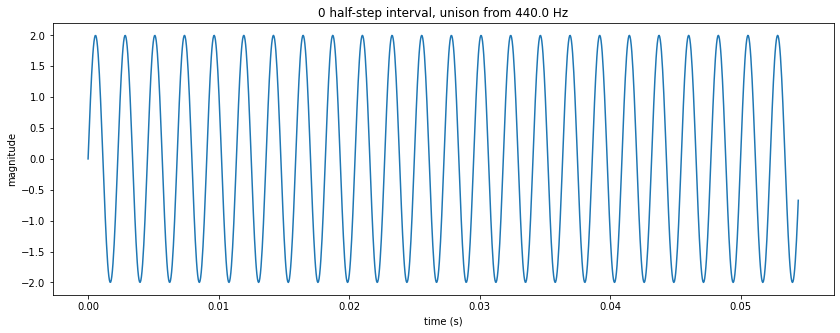

interval: min 2nd, Bb4
given note ratio: 233 / 220 = 1.05909 with gcd 2
closest simple ratio: 11 / 10
absolute diff in ratio btwn just and equal temperament: 0.04091


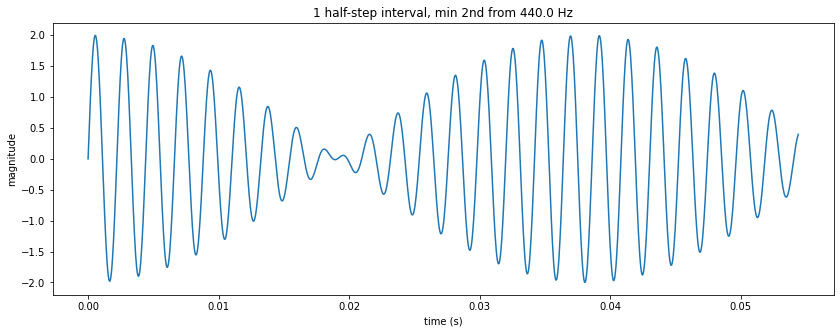

interval: maj 2nd, B4
given note ratio: 247 / 220 = 1.12273 with gcd 2
closest simple ratio: 9 / 8
absolute diff in ratio btwn just and equal temperament: 0.00227


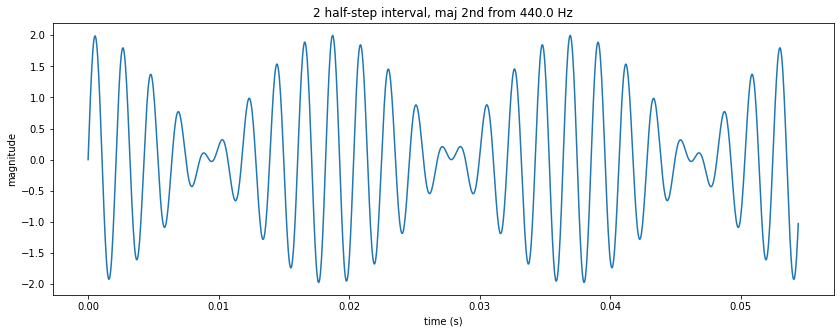

interval: min 3rd, C5
given note ratio: 523 / 440 = 1.18864 with gcd 1
closest simple ratio: 6 / 5
absolute diff in ratio btwn just and equal temperament: 0.01136


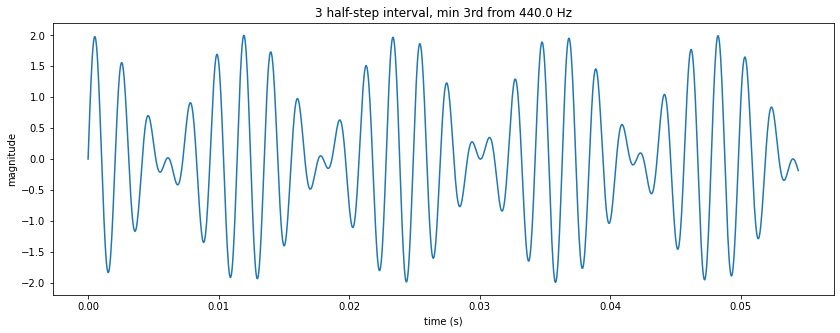

interval: maj 3rd, Db5
given note ratio: 277 / 220 = 1.25909 with gcd 2
closest simple ratio: 5 / 4
absolute diff in ratio btwn just and equal temperament: 0.00909


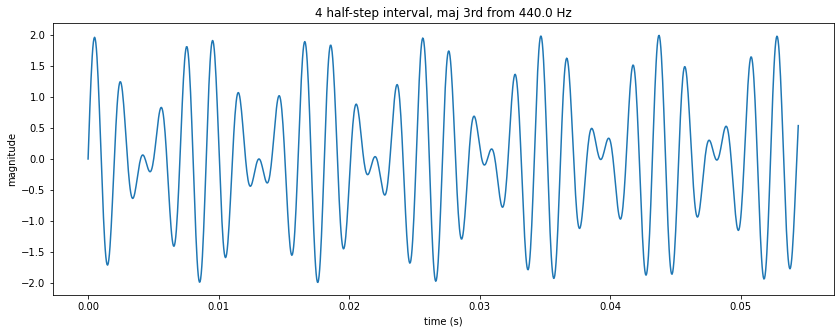

interval: prf 4th, D5
given note ratio: 587 / 440 = 1.33409 with gcd 1
closest simple ratio: 4 / 3
absolute diff in ratio btwn just and equal temperament: 0.00076


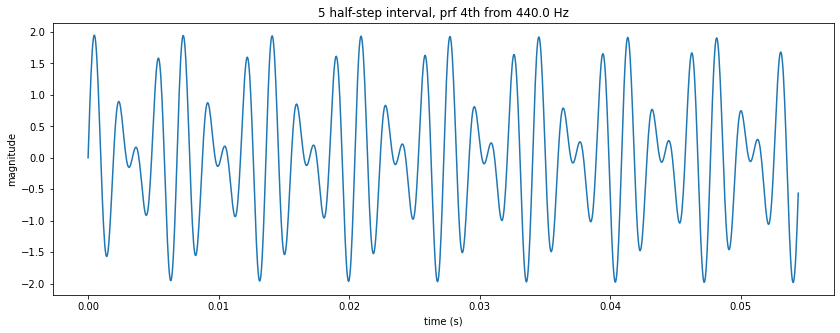

interval: tritone, Eb5
given note ratio: 311 / 220 = 1.41364 with gcd 2
closest simple ratio: 7 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


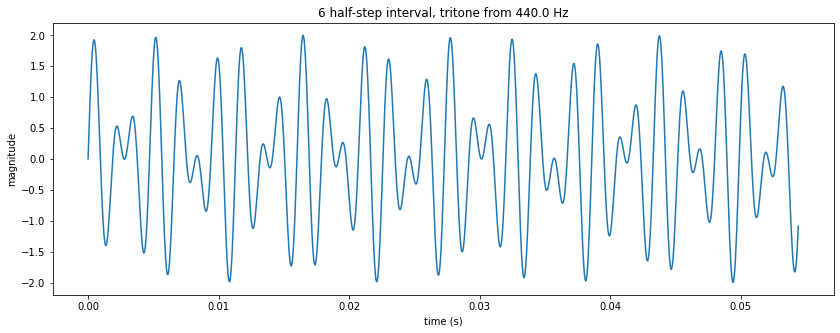

interval: prf 5th, E5
given note ratio: 659 / 440 = 1.49773 with gcd 1
closest simple ratio: 3 / 2
absolute diff in ratio btwn just and equal temperament: 0.00227


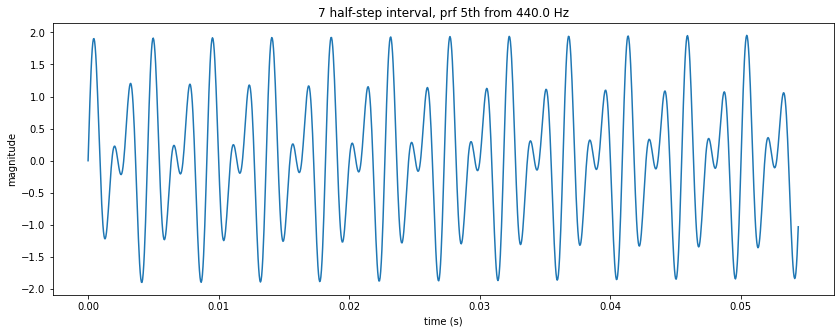

interval: min 6th, F5
given note ratio: 349 / 220 = 1.58636 with gcd 2
closest simple ratio: 8 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


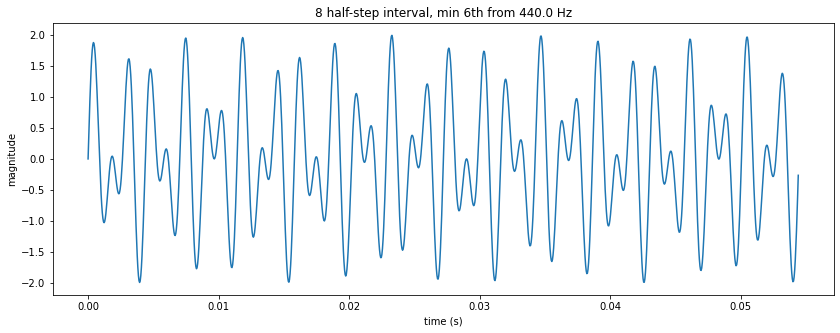

interval: maj 6th, Gb5
given note ratio: 37 / 22 = 1.68182 with gcd 20
closest simple ratio: 5 / 3
absolute diff in ratio btwn just and equal temperament: 0.01515


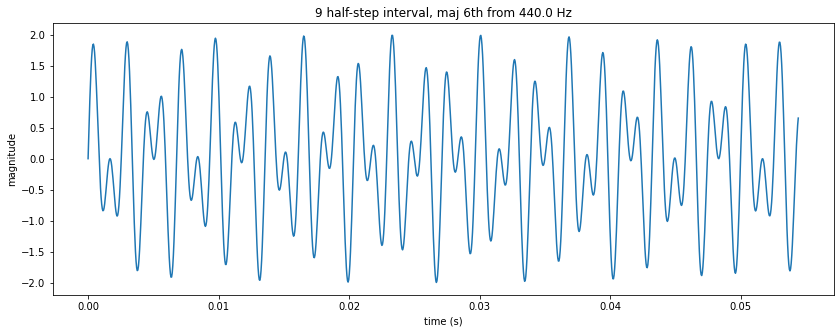

interval: dom 7th, G5
given note ratio: 98 / 55 = 1.78182 with gcd 8
closest simple ratio: 9 / 5
absolute diff in ratio btwn just and equal temperament: 0.01818


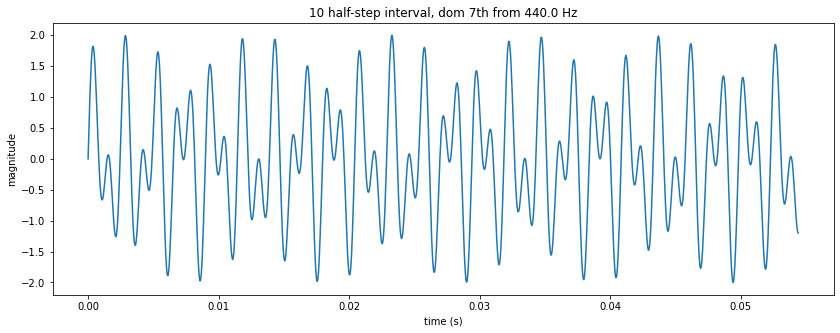

interval: maj 7th, Ab5
given note ratio: 831 / 440 = 1.88864 with gcd 1
closest simple ratio: 11 / 6
absolute diff in ratio btwn just and equal temperament: 0.05530


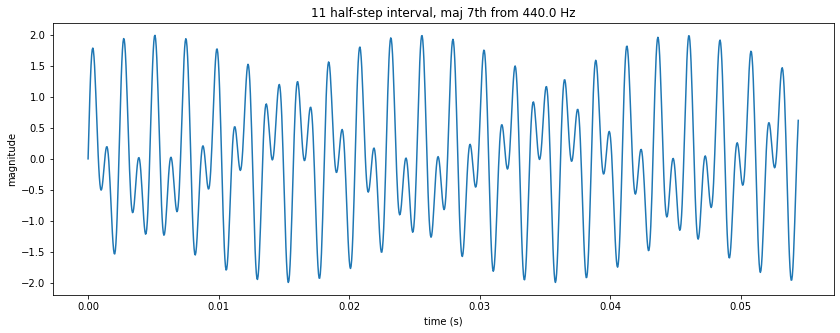

interval: octave, A5
given note ratio: 2 / 1 = 2.00000 with gcd 440
closest simple ratio: 2 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


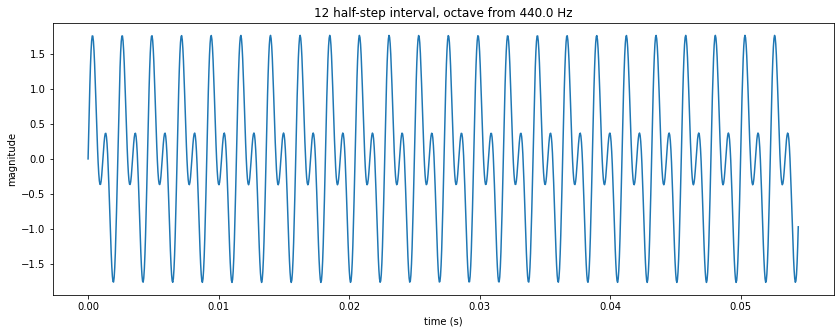

In [10]:
# interval analysis
# use a specific N value:
N = 1200
sCount = 0

# plot 12 intervals
offset = note_names.index('A4')  # starting index at fund
interval_ratio = {}
f0 = pitch['A4']     # fund
for j in range(13):
    
    # get interval stats
    fb = pitch[note_names[offset+j]]
    nume,deno,div,rat = f_to_ratio(fb,f0)
    c_num,c_den,diff = close_to_simple_ratio(nume,deno)
    interval_ratio[intervals[j]] = Fraction(c_num,c_den)
    
    # print interval stats
    print('interval: %s, %s' % (intervals[j],note_names[offset+j]))
    print('given note ratio: %d / %d = %.5f with gcd %d' %(nume,deno,rat,div))
    print('closest simple ratio: %d / %d' %(c_num,c_den))
    print('absolute diff in ratio btwn just and equal temperament: %.5f' % diff)
    
    # plot sum of interval
    x,x_title = two_pure_tones(N,fs,'A4',pitch,j)
    plot_waveforms(Ts,N,x,x_title)
    plt.show()

# Spectral Analysis:
* plot fft of previous waveform, without noise
* include markers at fundamentals and harmonics
* clean up noisy signal, turn into audio file

## Plot two notes
### Given two notes in scientific form and a specified number of samples
* Plot interesting waveforms, including harmonics
* experiment with random noise addition

interval between A3 and E4
interval between 220.0 Hz and 329.6 Hz


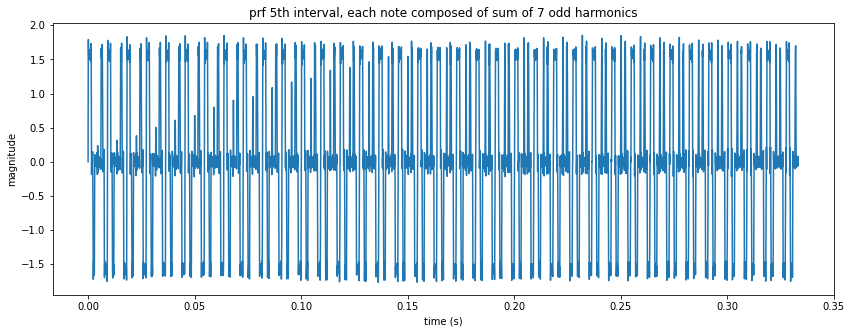

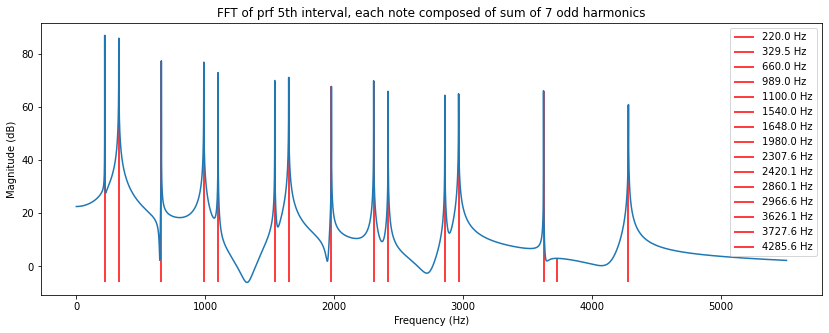

In [22]:
# plot two tones with harmonics summed
N = 2*fs
# choose notes
f0 = 'A3'
fb = 'E4'
print('interval between %s and %s' %(f0,fb))

# get interval name from distance between note names
semi_int = (note_names.index(fb) - note_names.index(f0)) % 12
interval_name = intervals[semi_int]

# combine waveforms and plot
num_harm = 7
harm_type = 'odd'
x1,x1_title = simple_harmonic(N,fs,f0,pitch,harm_type,num_harm)
x2,_ = simple_harmonic(N,fs,fb,pitch,harm_type,num_harm)
x = x1 + x2
x_title = '%s interval, each note composed of ' %(interval_name) + x1_title
x_short = x[:N//6]
N_short = N//6
plot_waveforms(Ts,N_short,x_short,x_title)

# plot spectral content
# take fft of previous array, x
Y = scipy.fft.fft(x)
Y_mag = 20*np.log10(np.absolute(Y))
f = np.linspace(0, fs, N)

# plot fft
plotlen = N//4
plt.figure(figsize=(14, 5))
plt.title('FFT of %s' % x_title)
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

#plot_fft(noisex,x_title,N,fs,15)

# find local max/min
mx,mn = findLocalMaximaMinima(N, Y_mag[:N])

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),Y_mag[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))
plt.legend(loc='upper right')

print('interval between %.1f Hz and %.1f Hz' %(pitch[f0],pitch[fb]))

output = fade(N,x)
write_audio(output,fs,sCount)

# create audio of time series and plot
#plot_waveforms(Ts,N,output,'noisy, filtered output')
ipd.Audio(output,rate=fs)

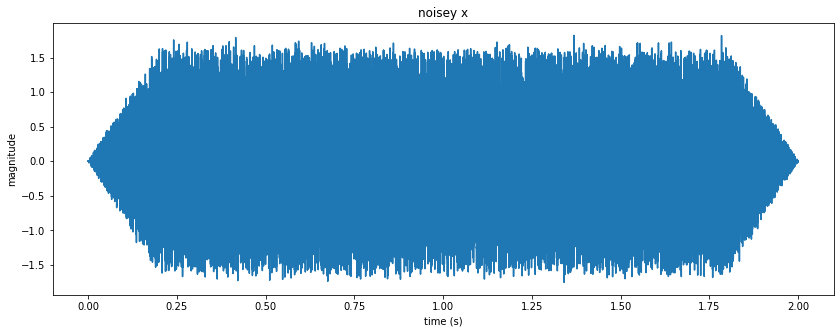

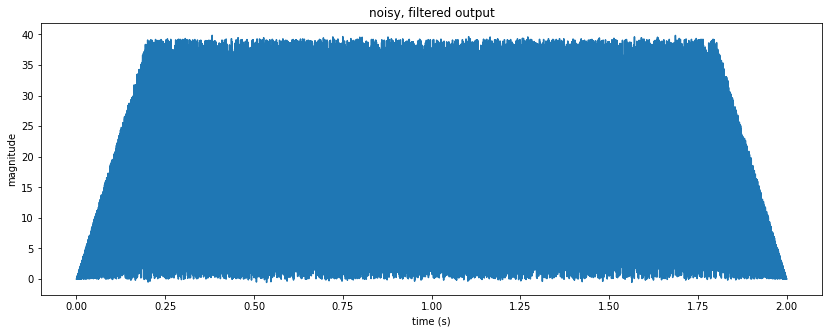

In [24]:
# add some weird noise
# take derivative, normalize, combine with random[0,1]
t = np.linspace(0,Ts*N,N)
dx = np.gradient(x, t)
norm = np.linalg.norm(dx)
norm_dx = dx/norm
rando = np.random.rand(N)
noise = norm_dx + rando

# combine noise and signal, plot
noisex = x * noise
plot_waveforms(Ts,N,noisex,'noisey x')

# ideal LPF
c = fs/N         # coeff
cutoff = 2000    # Hz
M = int(round(1/c * cutoff)) + 1
rect = np.zeros(N)
rect[:M] = 1/M * np.ones(M)
imp = abs(scipy.fft.ifft(rect))
imp = np.roll(imp,N//2)
fnoise = np.convolve(imp,noisex,'same')
norm = np.linalg.norm(fnoise)
x_filt = noise/norm

output = fade(N,x_filt)
#write_audio(output,fs,sCount)

# create audio of time series and plot
plot_waveforms(Ts,N,output,'noisy, filtered output')
ipd.Audio(output,rate=fs)

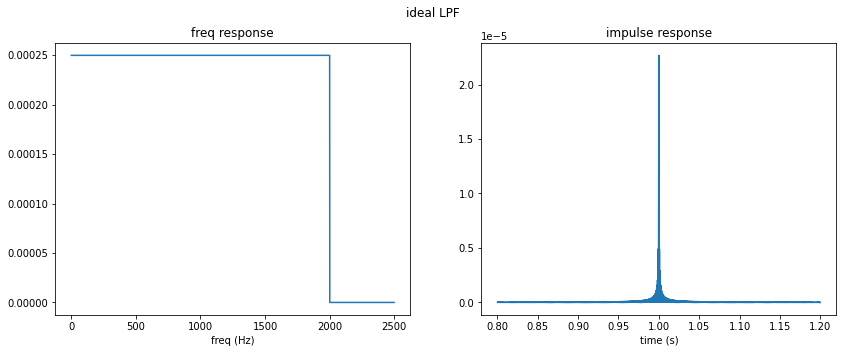

interval between 220.0 Hz and 329.6 Hz


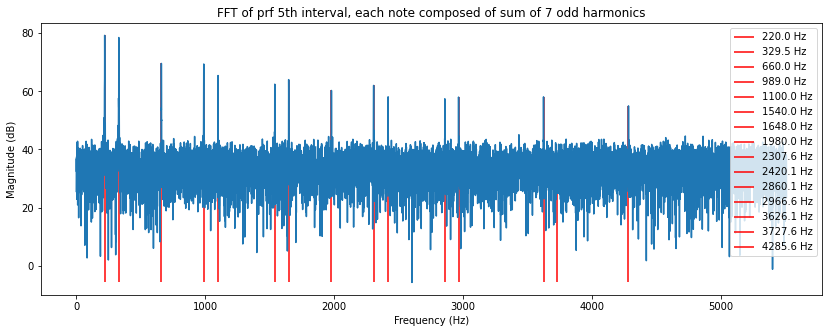

In [30]:
# plot spectral content
# take fft of previous array, x
Y = scipy.fft.fft(noisex)
Y_mag = 20*np.log10(np.absolute(Y))
f = np.linspace(0, fs, N)

# plot freq and impulse responses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('ideal LPF')
# plot freq response of LPF
fn = np.linspace(0,fs,N)
ax1.plot(fn[:5000],rect[:5000])
ax1.set_title('freq response')
ax1.set_xlabel('freq (Hz)')
ax2.plot(t[2*N//5:3*N//5],imp[2*N//5:3*N//5])
ax2.set_title('impulse response')
ax2.set_xlabel('time (s)')
plt.show()

# plot fft
#plot_fft(noisex,x_title,N,fs,15)

plotlen = N//4
plt.figure(figsize=(14, 5))
plt.title('FFT of %s' % x_title)
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

# find local max/min
# use mx from clean signal, above
#mx,mn = findLocalMaximaMinima(N, Y_mag[:N])

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),Y_mag[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))
plt.legend(loc='upper right')

print('interval between %.1f Hz and %.1f Hz' %(pitch[f0],pitch[fb]))

#output = fade(N,noisex)
#write_audio(output,fs,sCount)

# create audio of time series and plot
#plot_waveforms(Ts,N,output,'noisy, filtered output')
ipd.Audio(output,rate=fs)

In [43]:
# scale stuff
root = 'A4'
scale_name = 'major'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

root = 'A4'
scale_name = 'aeolian'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

root = 'D3'
scale_name = 'phrygian'
print('list %s %s scale:' % (root,scale_name))
print(list_scale(root,scale_name,scales,note_names))
print('')

# note interval
fund = 'A4'
interval = 2
print('given: %s fundamental,' % fund)
print('give the note %d half steps up: ' % interval)
print(note_interval('A4',2,note_names))

list A4 major scale:
['A4', 'B4', 'Db5', 'D5', 'E5', 'Gb5', 'Ab5']

list A4 aeolian scale:
['A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5']

list D3 phrygian scale:
['D3', 'Eb3', 'F3', 'G3', 'A3', 'Bb3', 'C4']

given: A4 fundamental,
give the note 2 half steps up: 
B4


In [44]:
# test audio generation
T = 2
N = T*fs
x,x_title = two_pure_tones(N,fs,'A2',pitch,7)
x = fade(N,x)
ipd.Audio(x,rate=fs)

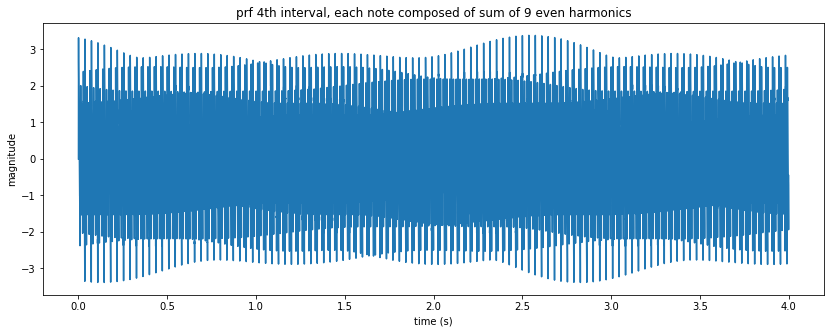

In [45]:
# more audio testing
T = 4
N = T*fs

f0 = 'E1'
fb = 'A1'
# get interval name from distance between note names
semi_int = (note_names.index(fb) - note_names.index(f0)) % 12
interval_name = intervals[semi_int]

num_harm = 9
harm_type = 'even'
x1,x1_title = simple_harmonic(N,fs,f0,pitch,harm_type,num_harm)
x2,_ = simple_harmonic(N,fs,fb,pitch,harm_type,num_harm)
x = x1 + x2
x_title = '%s interval, each note composed of ' %(interval_name) + x1_title
plot_waveforms(Ts,N,x,x_title)
plt.show()

# audio
x = fade(N,x)
ipd.Audio(x,rate=fs)